# Redes Neuronales y Aprendizaje Profundo

### Máster Universitario en Inteligencia Artificial

*Universidad Internacional de La Rioja (UNIR)*  
*Profesor: Pablo Negre*

### Clasificación de imágenes con CNN y Transfer Learning

#### Dataset: CIFAR-10

#### IMPORTANTE: se está entrenando con pocas épocas para que el código no tarde mucho en ejecutar. Si se desean resultados coherentes y óptimos, se deberán entrenar muchas más épocas (lo ideal es aprovechar el early stop)

### 0) Cargar dataset CIFAR-10

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------
# 1) Cargar dataset CIFAR-10
# -----------------------------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Clases que queremos mantener (para no tardar tanto durante el entrenamiento)
selected_classes = [0, 1, 2]  # 0: avión, 1: automóvil, 2: pájaro
class_names = ["avión", "automóvil", "pájaro"]

# Filtrar dataset para solo estas clases
train_mask = np.isin(y_train, selected_classes).flatten()
test_mask = np.isin(y_test, selected_classes).flatten()

x_train = x_train[train_mask]
y_train = y_train[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]

# Reasignar etiquetas para que queden 0,1,2
y_train = np.array([selected_classes.index(y[0]) for y in y_train])
y_test = np.array([selected_classes.index(y[0]) for y in y_test])

# Reducir dataset de entrenamiento a 5,000 imágenes
subset_size = 5000
x_train = x_train[:subset_size]
y_train = y_train[:subset_size]

print(f"Nuevo tamaño de entrenamiento: {x_train.shape[0]} imágenes")
print(f"Número de clases: {len(class_names)}")

Nuevo tamaño de entrenamiento: 5000 imágenes
Número de clases: 3


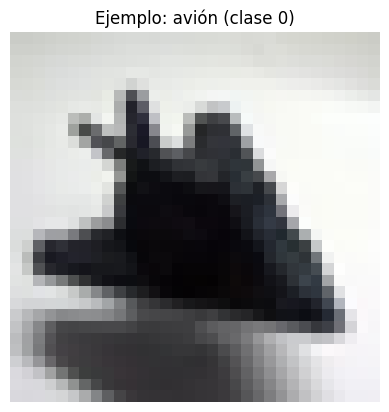

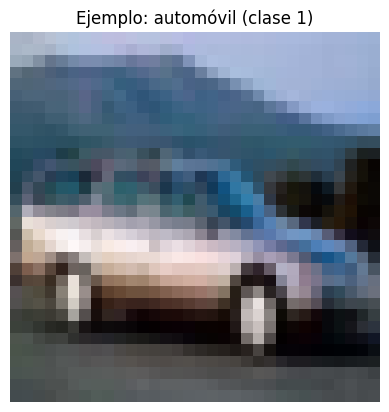

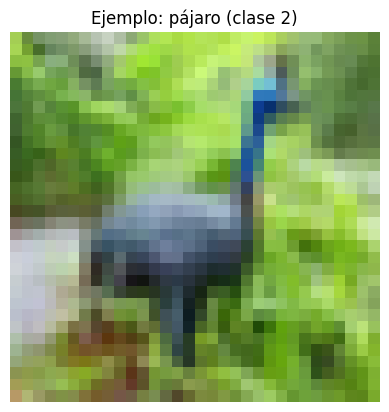


TRAIN (n=5000)
- avión     :  1654  (33.08%)
- automóvil :  1645  (32.90%)
- pájaro    :  1701  (34.02%)
¿Balanceadas? True (desviación máx vs 33.33%: 0.69%)

TEST (n=3000)
- avión     :  1000  (33.33%)
- automóvil :  1000  (33.33%)
- pájaro    :  1000  (33.33%)
¿Balanceadas? True (desviación máx vs 33.33%: 0.00%)


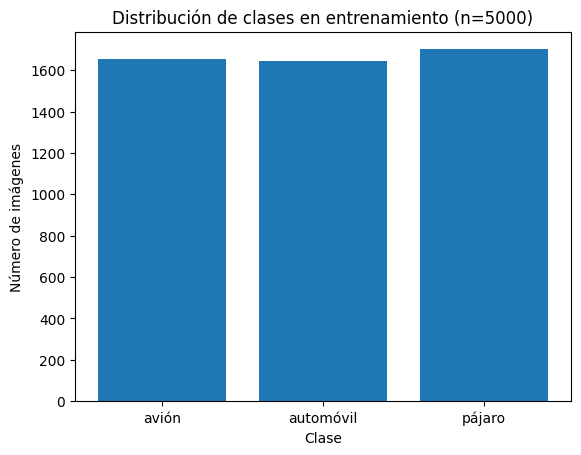

In [5]:
# -----------------------------------------------------------------------
# Mostrar ejemplo de cada clase y comprobar si el dataset está balanceado
# -----------------------------------------------------------------------

# --- 1) Mostrar un ejemplo por clase (figuras separadas, sin subplots) ---
for cls, name in enumerate(class_names):
    idx = np.where(y_train == cls)[0][0]  # primer índice de esa clase
    plt.figure()
    plt.imshow(x_train[idx])
    plt.axis('off')
    plt.title(f"Ejemplo: {name} (clase {cls})")
    plt.show()

# --- 2) Chequear balance en TRAIN y TEST ---
def resumen_balance(y, class_names, titulo=""):
    counts = np.bincount(y, minlength=len(class_names))
    total = counts.sum()
    pct = counts / total * 100
    print(f"\n{titulo} (n={total})")
    for n, c, p in zip(class_names, counts, pct):
        print(f"- {n:10s}: {c:5d}  ({p:5.2f}%)")
    uniform = 100.0 / len(class_names)
    max_dev = np.max(np.abs(pct - uniform))
    balanced = max_dev <= 5.0   # umbral simple ±5% contra distribución uniforme
    print(f"¿Balanceadas? {balanced} (desviación máx vs {uniform:.2f}%: {max_dev:.2f}%)")
    return counts, pct

train_counts, train_pct = resumen_balance(y_train, class_names, "TRAIN")
test_counts, test_pct   = resumen_balance(y_test,  class_names, "TEST")

# --- 3) Gráfico de barras de la distribución en TRAIN (una sola figura) ---
plt.figure()
plt.bar(class_names, train_counts)
plt.title(f"Distribución de clases en entrenamiento (n={len(y_train)})")
plt.ylabel("Número de imágenes")
plt.xlabel("Clase")
plt.show()


### 2) Modelo CNN propia (desde cero)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,139 (2.26 MB)

 Trainable params: 590,755 (2.25 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
63/63 - 48s - 766ms/step - accuracy: 0.6398 - loss: 1.0107 - val_accuracy: 0.3570 - val_loss: 4.5126 - learning_rate: 1.0000e-03
Epoch 2/10
63/63 - 36s - 566ms/step - accuracy: 0.7510 - loss: 0.6317 - val_accuracy: 0.3570 - val_loss: 4.7269 - learning_rate: 1.0000e-03
Epoch 3/10
63/63 - 40s - 634ms/step - accuracy: 0.7812 - loss: 0.5713 - val_accuracy: 0.3570 - val_loss: 5.1878 - learning_rate: 1.0000e-03
Epoch 4/10
63/63 - 36s - 576ms/step - accuracy: 0.8018 - loss: 0.5426 - val_accuracy: 0.4450 - val_loss: 4.3356 - learning_rate: 1.0000e-03
Epoch 5/10
63/63 - 37s - 586ms/step - accuracy: 0.8145 - loss: 0.4810 - val_accuracy: 0.4870 - val_loss: 4.5065 - learning_rate: 1.0000e-03
Epoch 6/10
63/63 - 35s - 556ms/step - accuracy: 0.8338 - loss: 0.4394 - val_accuracy: 0.5300 - val_loss: 2.0529 - learning_rate: 1.0000e-03
Epoch 7/10
63/63 - 37s - 584ms/step - accuracy: 0.8478 - loss: 0.4155 - val_accuracy: 0.6820 - val_loss: 1.2210 - learning_rate: 1.0000e-03
Epoch 8/10
63/63 - 3

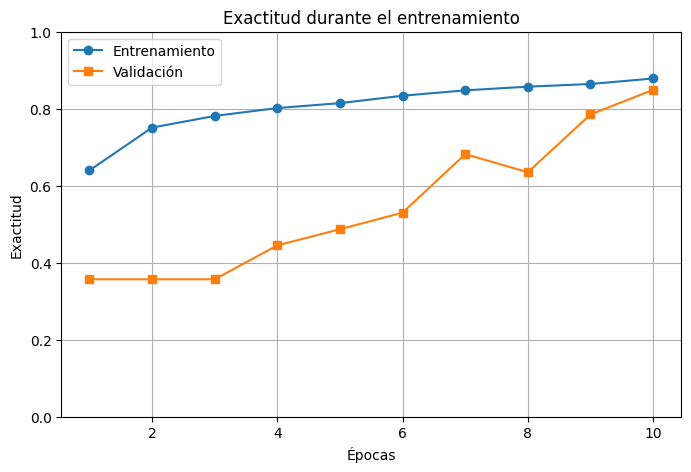

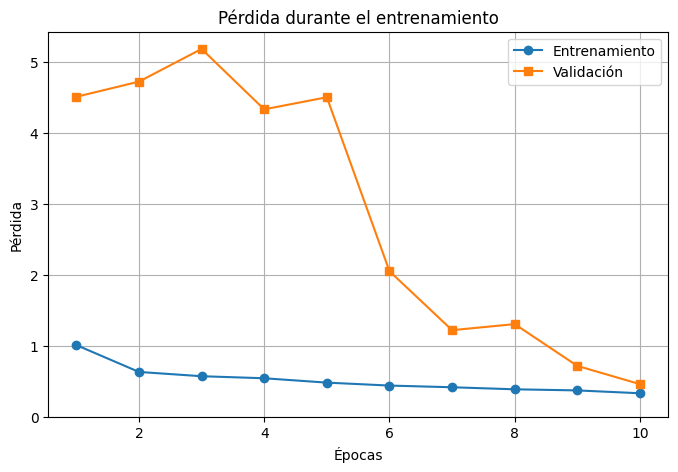

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step


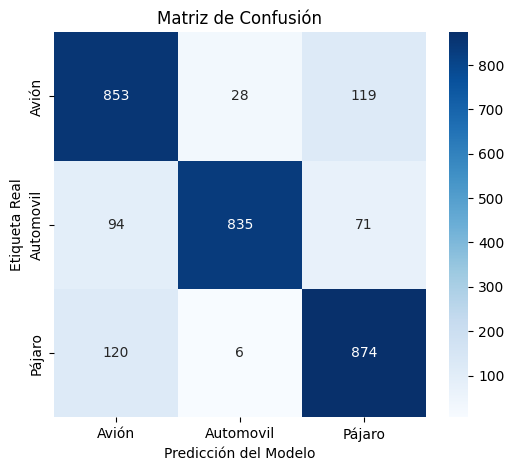

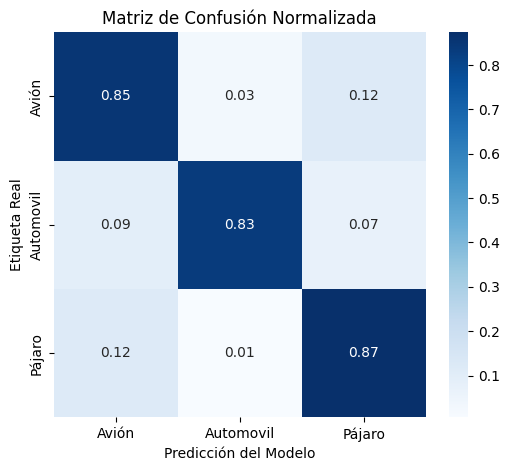

In [20]:
# =========================================================
# ARQUITECTURA CNN PARA CLASIFICACIÓN DE IMÁGENES
# Dataset esperado: Imágenes 32x32 con 3 canales (RGB).
# Número de clases en la salida: 3 (por ejemplo: avión / auto / pájaro)
# =========================================================

modelo_cnn = models.Sequential([

    # =========================================================
    # PRIMER BLOQUE CONVOLUCIONAL
    # =========================================================
    # La convolución extrae características visuales pequeñas, como bordes o texturas.
    layers.Conv2D(
        32, (3, 3),                  # 32 filtros de tamaño 3x3
        activation='relu',           # Función de activación (introduce no-linealidad)
        padding='same',              # Mantiene el tamaño espacial (32x32)
        input_shape=(32, 32, 3),     # Tamaño de entrada (alto, ancho, canales)
        kernel_regularizer=regularizers.l1_l2(1e-5, 1e-4)   # Penalización para evitar sobreajuste
    ),
    layers.BatchNormalization(),     # Normaliza activaciones -> acelera convergencia y estabilidad

    layers.Conv2D(
        32, (3, 3),
        activation='relu',
        padding='same'
    ),
    layers.BatchNormalization(),

    layers.MaxPooling2D(2, 2),       # Reduce resolución a la mitad (ej: 32x32 → 16x16)
    layers.Dropout(0.3),             # "Apaga" neuronas aleatoriamente → evita memorizar datos (overfitting)

    # =========================================================
    # SEGUNDO BLOQUE CONVOLUCIONAL
    # Similar al anterior, pero aumenta el número de filtros
    # para capturar características más complejas.
    # =========================================================
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.MaxPooling2D(2, 2),       # Reduce resolución nuevamente (16x16 → 8x8)
    layers.Dropout(0.4),             # Aumenta dropout → modelo menos propenso a sobreajustar

    # =========================================================
    # CAPAS FINALES (CLASIFICADOR)
    # =========================================================
    layers.Flatten(),                # Aplana los mapas de características para pasarlos a densas
    layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)  # Penalización L2 → reduce complejidad de pesos
    ),
    layers.Dropout(0.5),             # Dropout aún mayor para evitar sobreajuste

    layers.Dense(
        3,                           # Número de clases a predecir
        activation='softmax'         # Softmax → convierte salidas en probabilidades
    )
])

# =========================================================
# COMPILACIÓN DEL MODELO
# Define cómo se entrena la red (optimización + función de pérdida).
# =========================================================
modelo_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Adam → optimizador eficiente
    loss='sparse_categorical_crossentropy',  # Para etiquetas enteras (0,1,2) y no one-hot
    metrics=['accuracy']                     # Métrica principal a reportar
)

# Mostrar resumen del modelo (capas, parámetros, tamaños)
modelo_cnn.summary()

# =========================================================
# CALLBACKS (Ayudan durante el entrenamiento)
# =========================================================

# EarlyStopping:
# - Detiene el entrenamiento si la validación deja de mejorar.
# - Evita "sobreentrenar" y perder capacidad de generalización.
early_stop = EarlyStopping(
    monitor='val_loss',       # Observa la pérdida en validación
    patience=10,              # Espera 10 epochs antes de detener
    restore_best_weights=True # Recupera los mejores pesos logrados
)

# ReduceLROnPlateau:
# - Si el modelo no mejora → bajar la tasa de aprendizaje.
# - Permite seguir refinando pesos en lugar de estancarse.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,   # Reduce el learning rate a la mitad
    patience=5,   # Si 5 epochs sin mejora → reducir LR
    verbose=1
)

# =========================================================
# ENTRENAMIENTO DEL MODELO
# validation_split=0.2 → 20% de x_train se usa como validación
# =========================================================
hist_cnn = modelo_cnn.fit(
    x_train, y_train,
    epochs=10,              # Número máximo de pasadas por los datos
    batch_size=64,          # Tamaño de cada lote (batch)
    validation_split=0.2,   # Porcentaje reservado para validación
    callbacks=[early_stop, lr_scheduler],  # Utilizar callbacks
    verbose=2               # Modo de impresión "resumido"
)

# =========================================================
# EVALUACIÓN EN EL CONJUNTO DE TEST
# =========================================================
test_loss, test_acc = modelo_cnn.evaluate(x_test, y_test, verbose=0)
print(f"\n[Modelo propio] Exactitud en test: {test_acc:.3f}")


# =========================================================
# GRAFICAR CURVAS DE ENTRENAMIENTO
# =========================================================
# Extraemos métricas del historial
acc = hist_cnn.history['accuracy']
val_acc = hist_cnn.history['val_accuracy']
loss = hist_cnn.history['loss']
val_loss = hist_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)

# ---- Curva de Exactitud ----
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'o-', label='Entrenamiento')
plt.plot(epochs, val_acc, 's-', label='Validación')
plt.title('Exactitud durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# ---- Curva de Pérdida ----
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'o-', label='Entrenamiento')
plt.plot(epochs, val_loss, 's-', label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(bottom = 0)
plt.legend()
plt.grid(True)
plt.show()

# =========================================================
# MATRIZ DE CONFUSIÓN (CORRELACIÓN ENTRE CLASES)
# =========================================================
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Obtener predicciones
y_pred_probs = modelo_cnn.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Generar matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# 3. Etiquetas (CAMBIA ESTOS NOMBRES SI TUS CLASES TIENEN NOMBRE)
class_names = ["Avión", "Automovil", "Pájaro"]  # <--- pon aquí tus clases reales

# 4. Graficar matriz
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicción del Modelo")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()

# (Opcional) Matriz Normalizada (%)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicción del Modelo")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión Normalizada")
plt.show()


### 3) Modelo preentrenado: MobileNetV3Small (Transfer Learning)

/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 32, 32, 3) │          0 │ input_layer_5[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 16, 16,    │        432 │ rescaling_2[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 16, 16,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 16, 16,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 17, 17,    │          0 │ activation_36[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 8, 8, 16)  │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 8, 8, 16)  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 8, 8, 16)  │          0 │ expanded_conv_de… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_28[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_18         │ (None, 1, 1, 16)  │          0 │ re_lu_29[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 8, 8, 16)  │          0 │ re_lu_28[0][0],   │
│ (Multiply)          │                   │            │ multiply_18[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 8, 8, 16)  │        256 │ expanded_conv_sq

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 576)            │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,363 (3.87 MB)

 Trainable params: 1,001,251 (3.82 MB)

 Non-trainable params: 12,112 (47.31 KB)

Epoch 1/20
63/63 - 48s - 755ms/step - accuracy: 0.4918 - loss: 1.4210 - val_accuracy: 0.3570 - val_loss: 1.1260 - learning_rate: 1.0000e-03
Epoch 2/20
63/63 - 7s - 109ms/step - accuracy: 0.5845 - loss: 0.9311 - val_accuracy: 0.3570 - val_loss: 1.2304 - learning_rate: 1.0000e-03
Epoch 3/20
63/63 - 8s - 129ms/step - accuracy: 0.6532 - loss: 0.7836 - val_accuracy: 0.3570 - val_loss: 1.5298 - learning_rate: 1.0000e-03
Epoch 4/20
63/63 - 10s - 165ms/step - accuracy: 0.6952 - loss: 0.7171 - val_accuracy: 0.3680 - val_loss: 1.2612 - learning_rate: 1.0000e-03
Epoch 5/20
63/63 - 7s - 106ms/step - accuracy: 0.7040 - loss: 0.6767 - val_accuracy: 0.3570 - val_loss: 1.3311 - learning_rate: 1.0000e-03
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 - 8s - 130ms/step - accuracy: 0.7255 - loss: 0.6639 - val_accuracy: 0.3570 - val_loss: 1.1600 - learning_rate: 1.0000e-03
Epoch 7/20
63/63 - 7s - 113ms/step - accuracy: 0.7558 - loss: 0.5871 - val_accuracy: 0.

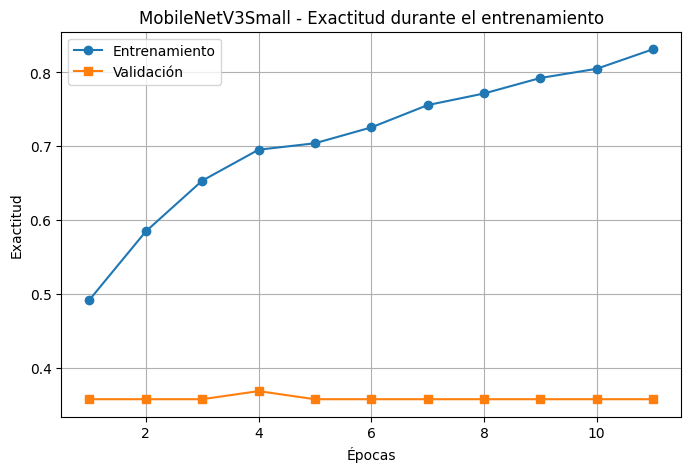

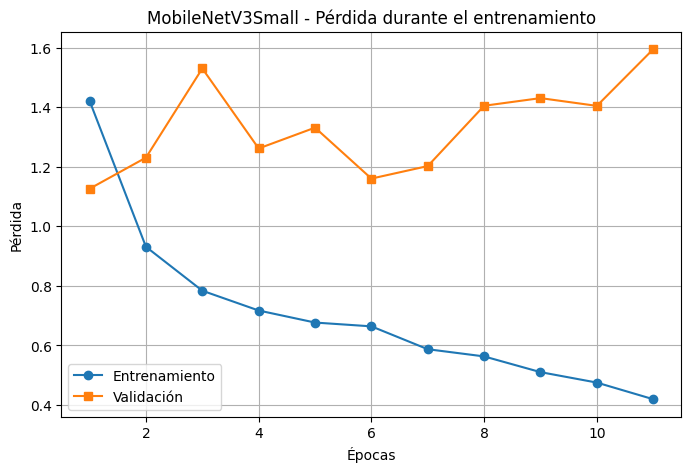

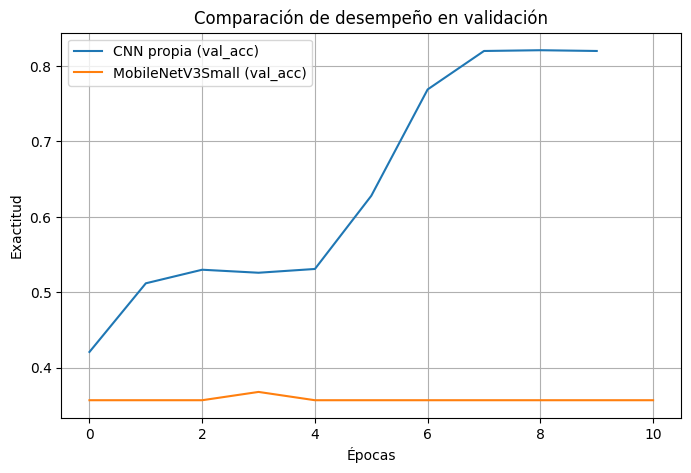

In [16]:
# Cargamos MobileNetV3Small preentrenado en ImageNet
# - include_top=False elimina la parte densa final
# - pooling='avg' realiza un Global Average Pooling sobre las features
base_model = MobileNetV3Small(
    input_shape=(32, 32, 3),  # Imágenes de 32x32 (como CIFAR-10)
    include_top=False,        # Excluimos las capas densas finales de ImageNet
    weights='imagenet',       # Usamos pesos preentrenados
    pooling='avg'             # Obtiene un vector de características globales
)

# ========================================================================
# ENTRENAR (O NO) CAPAS BASE -- Descomentar línea de código según deseamos
# ========================================================================
# FORMA DE NO RE-ENTRENAR EL MODELO BASE
# No entrenamos la base convolucional para preservar los pesos de ImageNet
base_model.trainable = False

# FORMA DE RE-ENTRENAR SOLO x ÚLTIMAS CAPAS DEL MODELO BASE (EN ESTE CASO 5)
# Congelamos todo
base_model.trainable = False
# Re-entrenamos solo las últimas 5 capas
for layer in base_model.layers[-5:]:
    layer.trainable = True

# FORMA DE RE-ENTRENAR TODAS LAS CAPAS DEL MODELO BASE
# Entrenar todas las capas convolucionales del modelo base
base_model.trainable = True

base_model.summary()

# =========================================================
# CONSTRUCCIÓN DEL MODELO SECUENCIAL
# =========================================================
modelo_mobilenet = models.Sequential([
    base_model,                       # Red base preentrenada
    layers.Dropout(0.3),              # Regularización
    layers.Dense(128, activation='relu'),  # Capa completamente conectada
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax') # Capa de salida (3 clases)
])

# =========================================================
# COMPILACIÓN DEL MODELO
# =========================================================
modelo_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',  # Para etiquetas enteras (no one-hot)
    metrics=['accuracy']
)

# Mostrar la arquitectura del modelo
modelo_mobilenet.summary()

# =========================================================
# ENTRENAMIENTO DEL MODELO
# =========================================================
# Entrenamos solo las capas nuevas añadidas encima del modelo base
hist_mobile = modelo_mobilenet.fit(
    x_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,          # 20% para validación
    callbacks=[early_stop, lr_scheduler],  # Callbacks definidos antes
    verbose=2
)

# =========================================================
# EVALUACIÓN
# =========================================================
test_loss_m, test_acc_m = modelo_mobilenet.evaluate(x_test, y_test, verbose=0)
print(f"\n[MobileNetV3Small] Exactitud en test: {test_acc_m:.3f}")

# =========================================================
# GRAFICAR CURVAS DE ENTRENAMIENTO (MobileNetV3Small)
# =========================================================
acc_m = hist_mobile.history['accuracy']
val_acc_m = hist_mobile.history['val_accuracy']
loss_m = hist_mobile.history['loss']
val_loss_m = hist_mobile.history['val_loss']
epochs_m = range(1, len(acc_m) + 1)

# ---- Curva de Exactitud ----
plt.figure(figsize=(8, 5))
plt.plot(epochs_m, acc_m, 'o-', label='Entrenamiento')
plt.plot(epochs_m, val_acc_m, 's-', label='Validación')
plt.title('MobileNetV3Small - Exactitud durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()
plt.grid(True)
plt.show()

# ---- Curva de Pérdida ----
plt.figure(figsize=(8, 5))
plt.plot(epochs_m, loss_m, 'o-', label='Entrenamiento')
plt.plot(epochs_m, val_loss_m, 's-', label='Validación')
plt.title('MobileNetV3Small - Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

# =========================================================
# COMPARACIÓN DE RESULTADOS ENTRE MODELOS
# =========================================================
plt.figure(figsize=(8, 5))
plt.plot(hist_cnn.history['val_accuracy'], label='CNN propia (val_acc)')
plt.plot(hist_mobile.history['val_accuracy'], label='MobileNetV3Small (val_acc)')
plt.title('Comparación de desempeño en validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()
plt.grid(True)
plt.show()


### 4) Uso de data augmentation

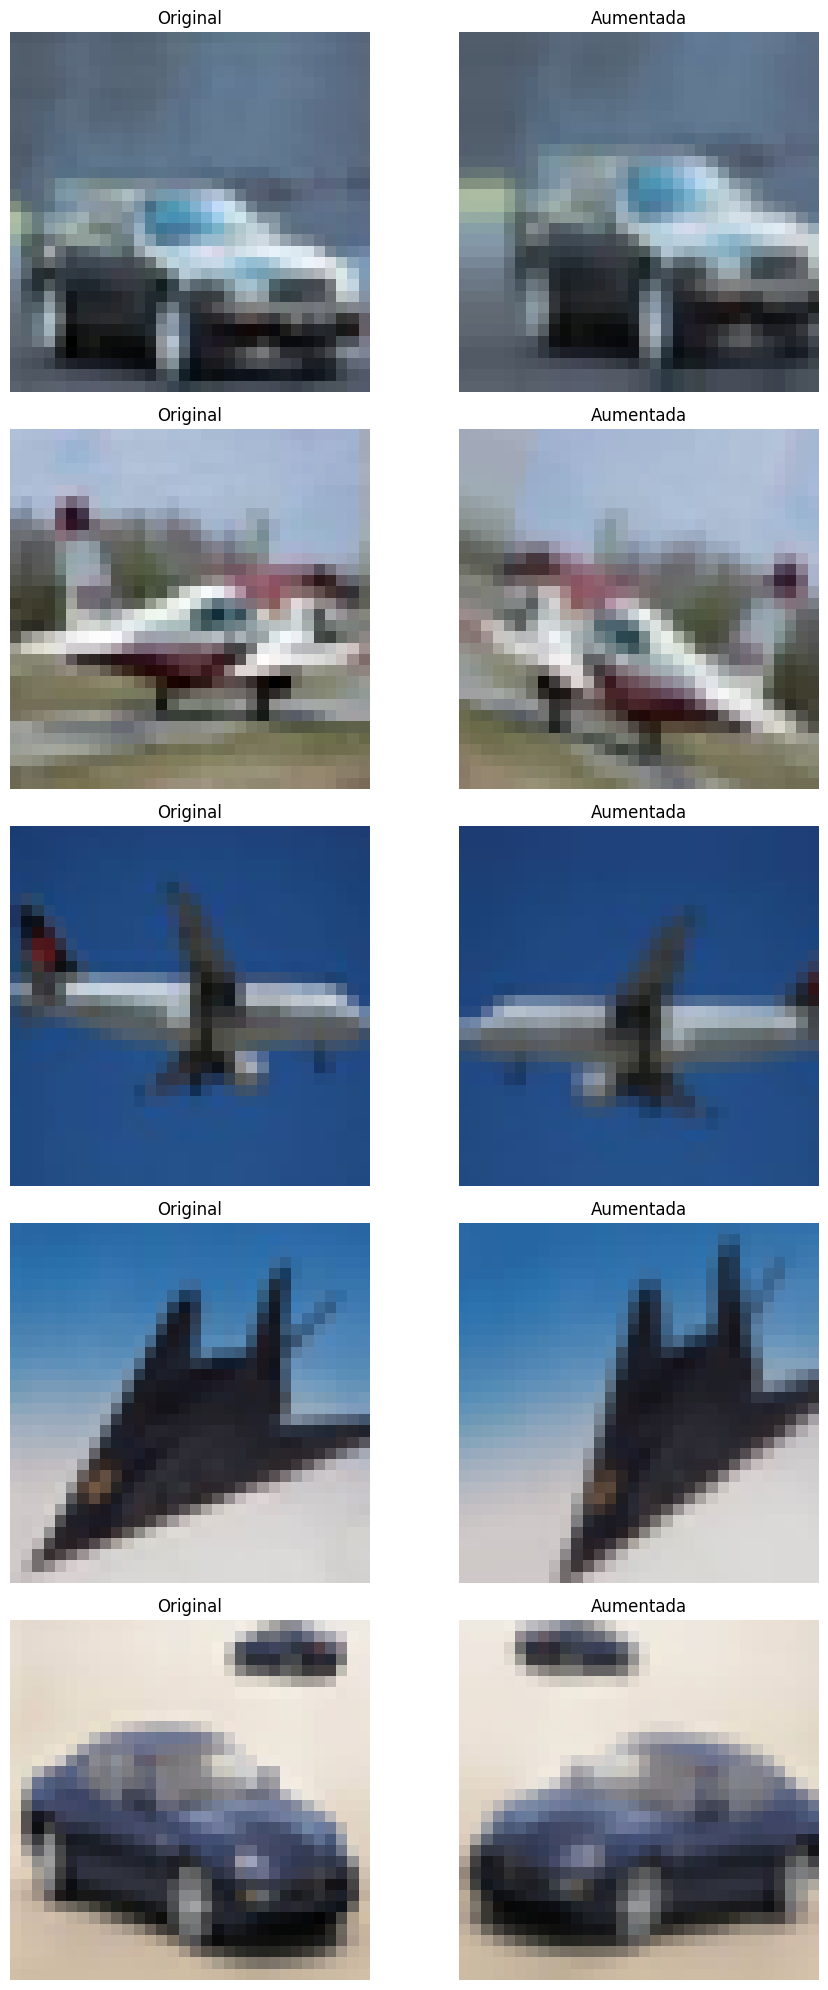

Epoch 1/2
62/62 - 11s - 184ms/step - accuracy: 0.5668 - loss: 0.9440 - val_accuracy: 0.3417 - val_loss: 1.2043 - learning_rate: 2.5000e-04
Epoch 2/2


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 - 1s - 10ms/step - accuracy: 0.5312 - loss: 1.0439 - val_accuracy: 0.3417 - val_loss: 1.2050 - learning_rate: 2.5000e-04

[MobileNetV3Small + Augmentación] Exactitud en test: 0.333


In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Dividir los datos en entrenamiento y validación ---
x_train_aug, x_val, y_train_aug, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

# --- 2. Generador con AUMENTACIÓN para ENTRENAMIENTO ---
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(x_train_aug)

train_generator = train_datagen.flow(
    x_train_aug, y_train_aug, batch_size=64
)

# --- 3. Generador SIN aumentación para VALIDACIÓN ---
val_datagen = ImageDataGenerator()

val_generator = val_datagen.flow(
    x_val, y_val, batch_size=64, shuffle=False
)

# --- 4. Mostrar ejemplos de augmentación ---
num_examples = 5
plt.figure(figsize=(10, 4 * num_examples))

for i in range(num_examples):
    img = x_train_aug[i]
    img_expanded = np.expand_dims(img, 0)
    aug_img = next(train_datagen.flow(img_expanded, batch_size=1))[0]

    plt.subplot(num_examples, 2, 2*i + 1)
    plt.imshow((img * 255).astype(np.uint8))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(num_examples, 2, 2*i + 2)
    plt.imshow((aug_img * 255).astype(np.uint8))
    plt.title("Aumentada")
    plt.axis("off")

plt.tight_layout()
plt.show()

# --- 5. ENTRENAR EL MODELO ---
hist_mobile = modelo_mobilenet.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    steps_per_epoch=len(x_train_aug) // 64,
    validation_steps=len(x_val) // 64,
    callbacks=[early_stop, lr_scheduler],
    verbose=2
)

# Se aconseja añadir Early stop como en los casos anteriores

# --- 6. EVALUACIÓN FINAL ---
test_loss_m, test_acc_m = modelo_mobilenet.evaluate(x_test, y_test, verbose=0)
print(f"\n[MobileNetV3Small + Augmentación] Exactitud en test: {test_acc_m:.3f}")


### NOTAS FINALES
- La CNN propia fue entrenada desde cero con regularización L1+L2, BatchNormalization y Dropout
- MobileNetV3Small se usa como extractor de características (Transfer Learning).
- Solo se entrenan las capas densas añadidas (la base está congelada).
- Ambos modelos se entrenan sobre CIFAR-10 con validación del 20%.
- Puedes descongelar las últimas capas de MobileNet para un fine-tuning posterior.
